In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import skeletor as sk

from skeletor.data import loadTestDataset, TEST_DATASETS_2D, TEST_DATASETS_3D
from skeletor.skeleton import LaplacianContractionSkeleton
from skeletor.utils import plotSpatialGraph

import time
from tqdm import tqdm
import robust_laplacian

from pc_skeletor import SLBC, LBC, Dataset
import open3d as o3d

from sklearn.cluster import OPTICS, DBSCAN
from sklearn.decomposition import TruncatedSVD
from scipy.spatial import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load data

In [136]:
#points = loadTestDataset('2d_curve_3', extraNoise=.005)
points = np.load('/home/jack/Workspaces/data/point_clouds/2d_web_scan.npy')
#points = np.load('/home/jack/Workspaces/data/point_clouds/latro_sheet_2024-07-11_A.npy')
dsFactor = 1
order = np.arange(points.shape[0])
np.random.shuffle(order)
points = points[order][::dsFactor,:]
#cmScaling = np.array([4800/15, 8000/21, 20000/16.5])
#points = points*cmScaling

# Convert to an open3d point cloud
# pointCloud = o3d.geometry.PointCloud()

# pointCloud.points = o3d.utility.Vector3dVector(points)

# o3d.visualization.draw_geometries([pointCloud])
LaplacianContractionSkeleton(points).plot(plotSkeleton=False, backend='o3d')
print(len(points))

62577


## Compute Laplacian

Computed L


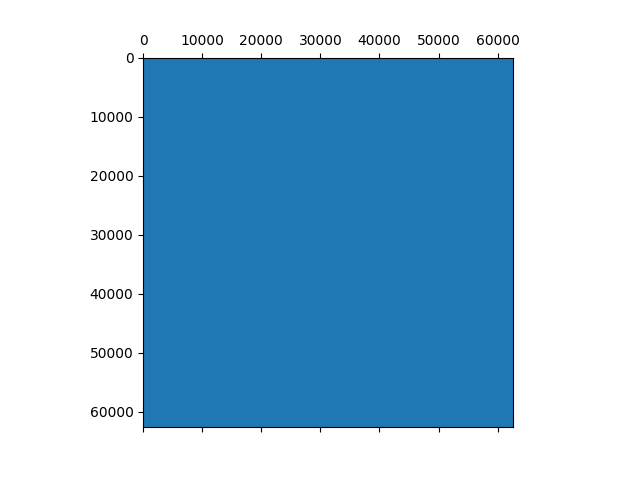

In [137]:
%matplotlib widget
L, M = robust_laplacian.point_cloud_laplacian(points)

print('Computed L')

plt.spy(L, markersize=1)
plt.show()

## Identify clusters

In [138]:
kdTree = KDTree(points)
nnDistances, nnIndices = kdTree.query(points, 2)
avgNNDistance = np.mean(nnDistances[:,1])

#cgDensityField, cgCorner = courseGrainField(self.points, latticeSpacing=avgNNDistance, returnCorner=True)
#avgDensity = np.mean(cgDensityField) # * nBoxes/numFilledBoxes

eps = avgNNDistance*2
labels = DBSCAN(eps=eps, leaf_size=20).fit(points).labels_

print(f'Found {np.max(labels)+1} clusters')

## Show clusters

In [139]:
# Plot all clusters
colors = plt.get_cmap("tab20c")(labels / (np.max(labels) if np.max(labels) > 0 else 1))
colors[labels < 0] = 0

# Convert to an open3d point cloud
pointCloud = o3d.geometry.PointCloud()
pointCloud.points = o3d.utility.Vector3dVector(points)
pointCloud.colors = o3d.utility.Vector3dVector(colors[:,:3])

o3d.visualization.draw_geometries([pointCloud])

## Reorder the points according to the clustering

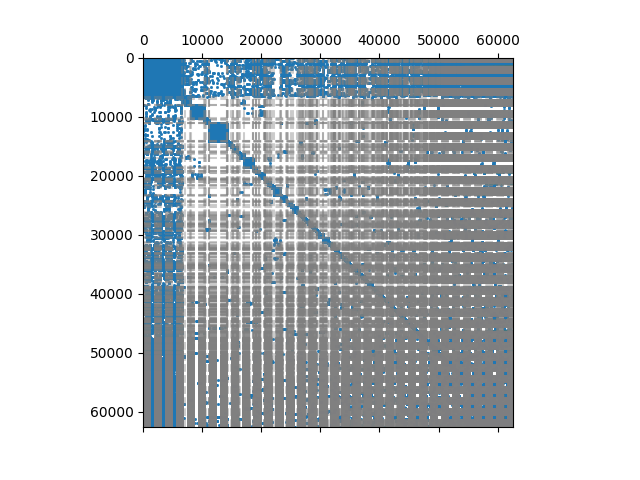

In [140]:
for _ in range(20):
    plt.close()

orderedPoints = []
groupBoundaries = []
for i in np.unique(labels):
    clusterPoints = points[labels == i]
    orderedPoints += list(clusterPoints)
    groupBoundaries += [len(clusterPoints)]

orderedPoints = np.array(orderedPoints)
orderedLabels = np.concatenate([np.repeat(i, g) for i,g in enumerate(groupBoundaries)])
groupBoundaries = np.cumsum(groupBoundaries)

L, M = robust_laplacian.point_cloud_laplacian(orderedPoints)

plt.spy(L, markersize=1)
for x in groupBoundaries:
    plt.axvline(x, linestyle='--', c='gray', alpha=.4)
    plt.axhline(x, linestyle='--', c='gray', alpha=.4)

plt.show()

## Factorize the laplacian

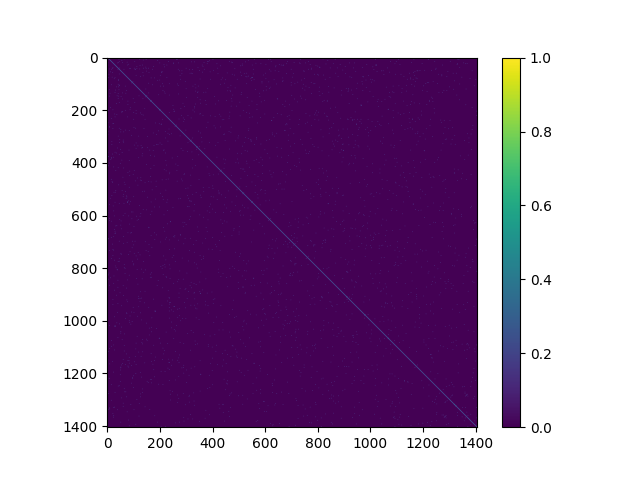

In [141]:
plt.close()
# Generate an adjacency matrix of the clusters
factorizedLArr = []
# Start from 1 to ignore unclassified points
for i in np.unique(orderedLabels)[1:]-1:
    factorizedLArr.append(L[groupBoundaries[i]:groupBoundaries[i+1], groupBoundaries[i]:groupBoundaries[i+1]].todense())

# Sum each factorized square in the laplacian matrix
# to see which clusters are neighbors to each other.
# Formally, this means that two clusters are neighbors
# if at least one point in one cluster is adjacent (nearby) to one
# point in the other cluster.
clusterAdjMat = np.zeros((len(factorizedLArr), len(factorizedLArr)))
for i in np.unique(orderedLabels)[1:]-1:
    for j in np.unique(orderedLabels)[1:]-1:
        clusterAdjMat[i,j] = np.sum(np.abs(L[groupBoundaries[i]:groupBoundaries[i+1], groupBoundaries[j]:groupBoundaries[j+1]]))

plt.imshow(clusterAdjMat != 0)
plt.colorbar()
plt.show()

## Plot a single cluster and its neighbors

In [129]:
# Plot a single cluster and its neighbors
clusterIndex = 10

# Convert to an open3d point cloud
pointCloud = o3d.geometry.PointCloud()
pointCloud.points = o3d.utility.Vector3dVector(points)
pointCloud.paint_uniform_color(np.array([0.1, 0.1, 0.1]))

singleCluster = o3d.geometry.PointCloud()
# Need the +1 here because we have to ignore the "first" cluster, which is
# actually points that don't belong to a cluster
singleCluster.points = o3d.utility.Vector3dVector(orderedPoints[orderedLabels == clusterIndex+1])
singleCluster.paint_uniform_color(np.array([0.9, 0.1, 0.1]))

neighbors = o3d.geometry.PointCloud()
# See above note about the +1
neighborIndices = [o in np.where(clusterAdjMat[clusterIndex] != 0)[0]+1 for o in orderedLabels]
neighbors.points = o3d.utility.Vector3dVector(orderedPoints[neighborIndices])
neighbors.paint_uniform_color(np.array([0.1, 0.9, 0.1]))

o3d.visualization.draw_geometries([pointCloud, neighbors, singleCluster])

## Perform contraction on each cluster individually

In [118]:
# Perform contraction on each cluster individually
contractedPoints = []
for i in tqdm(np.unique(orderedLabels)[1:]):

    clusterPoints = orderedPoints[orderedLabels == i]
    skeleton = LaplacianContractionSkeleton(clusterPoints, maxIterations=2)
    skeleton.contractPointCloud()
    contractedPoints += list(skeleton.contractedPoints)

contractedPoints = np.array(contractedPoints)

100%|████████████████████████████████| 69/69 [00:00<00:00, 138.01it/s]


In [119]:
# Plot all clusters
colors = plt.get_cmap("tab20c")(labels / (np.max(labels) if np.max(labels) > 0 else 1))
colors[labels < 0] = 0

# Convert to an open3d point cloud
pointCloud = o3d.geometry.PointCloud()
pointCloud.points = o3d.utility.Vector3dVector(contractedPoints)
pointCloud.colors = o3d.utility.Vector3dVector(colors[:,:3])

o3d.visualization.draw_geometries([pointCloud])

## Perform contraction on each cluster including its neighbors

In [142]:
%matplotlib inline
# Perform contraction on each cluster individually
contractedPoints = []
for i in tqdm(np.unique(orderedLabels)[1:]):
    # if i == -1:
    #     continue
        
    # This will actually include the cluster itself, since every cluster
    # is adjacent to itself
    # Could add some threshold here such that the adjacency matrix
    # value (sum of the laplacian matrix) has to be greater than a certain
    # magnitude.
    neighborClusterIndices = np.where(clusterAdjMat[i-1] != 0)[0]+1
    neighborPointIndices = [o in neighborClusterIndices for o in orderedLabels]
    neighborPoints = orderedPoints[neighborPointIndices]
    
    # Contract
    skeleton = LaplacianContractionSkeleton(neighborPoints)
    skeleton.contractPointCloud()
    
    # Now we have to only take the real points back out
    # Note that this indexing is relative to the list neighborPoints,
    # NOT the whole orderedPoints array.
    clusterIndices = np.where(orderedLabels[neighborPointIndices] == i)[0]
    contractedPoints += list(skeleton.contractedPoints[clusterIndices])

    # print(len(clusterIndices))
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')

    # ax.scatter(*neighborPoints.T, c='gray', alpha=0.5)
    # ax.scatter(*neighborPoints[clusterIndices].T, c='tab:red')
    # plt.show()
contractedPoints = np.array(contractedPoints)

 19%|█████▋                        | 264/1405 [01:17<02:48,  6.77it/s]/home/jack/anaconda3/envs/311/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:276: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
100%|█████████████████████████████| 1405/1405 [04:54<00:00,  4.77it/s]


In [151]:
contractedPoints.shape

(55966, 3)

In [152]:
# Plot all clusters
colors = plt.get_cmap("tab20c")(orderedLabels / (np.max(orderedLabels) if np.max(orderedLabels) > 0 else 1))
colors[orderedLabels < 0] = 0

# Convert to an open3d point cloud
pointCloud = o3d.geometry.PointCloud()
pointCloud.points = o3d.utility.Vector3dVector(points)
pointCloud.paint_uniform_color([0,0,0])

pointCloud2 = o3d.geometry.PointCloud()
pointCloud2.points = o3d.utility.Vector3dVector(contractedPoints)
pointCloud2.colors = o3d.utility.Vector3dVector(colors[:,:3])

o3d.visualization.draw_geometries([pointCloud2])

## Contract the entire point cloud at once

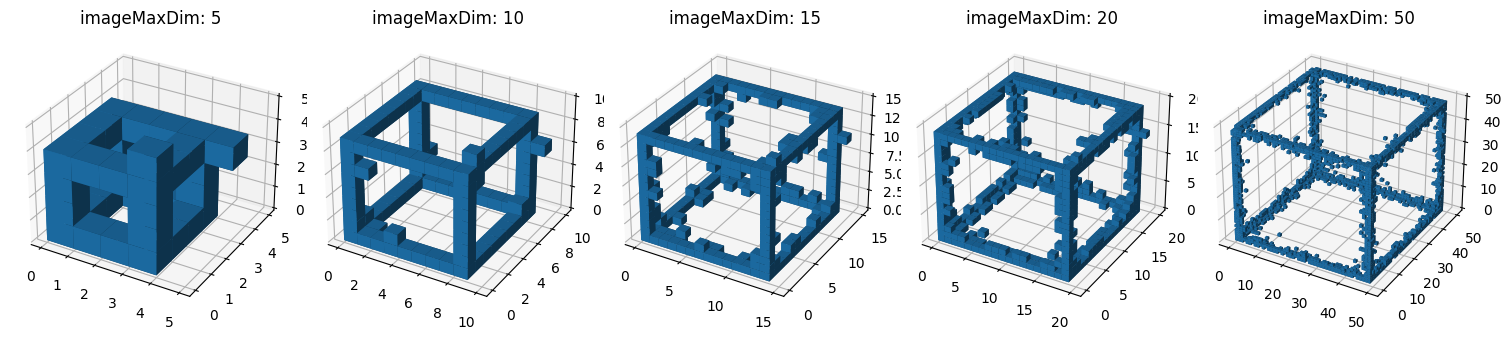

In [3]:
sizeArr = [5, 10, 15, 20, 50]
fig = plt.figure(figsize=(len(sizeArr)*3, 4))

for i in range(len(sizeArr)):
    
    img = sk.utils.pointsToImage(points, np.repeat(sizeArr[i], 3))
    
    ax = fig.add_subplot(1, len(sizeArr), i+1, projection='3d')
    ax.voxels(img)
    ax.set_title(f'imageMaxDim: {sizeArr[i]}')
    
fig.tight_layout()
plt.show()

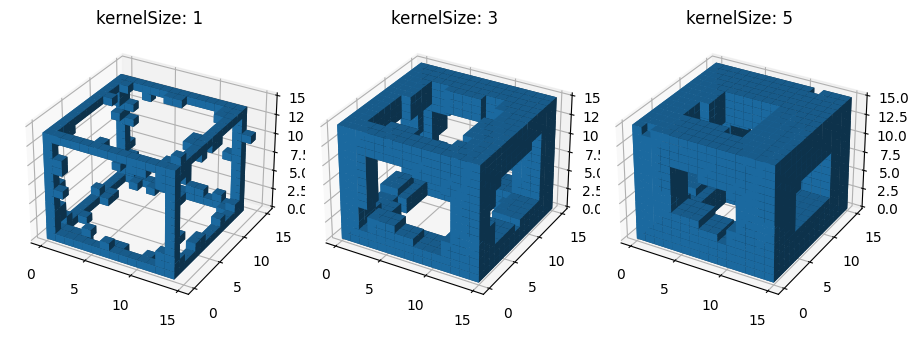

In [4]:
kernelArr = [1, 3, 5]
imageMaxSize = 15
fig = plt.figure(figsize=(len(kernelArr)*3, 4))

for i in range(len(kernelArr)):
    
    img = sk.utils.pointsToImage(points, np.repeat(imageMaxSize, 3), kernelArr[i])
    
    ax = fig.add_subplot(1, len(kernelArr), i+1, projection='3d')
    ax.voxels(img)
    ax.set_title(f'kernelSize: {kernelArr[i]}')
fig.tight_layout()
plt.show()

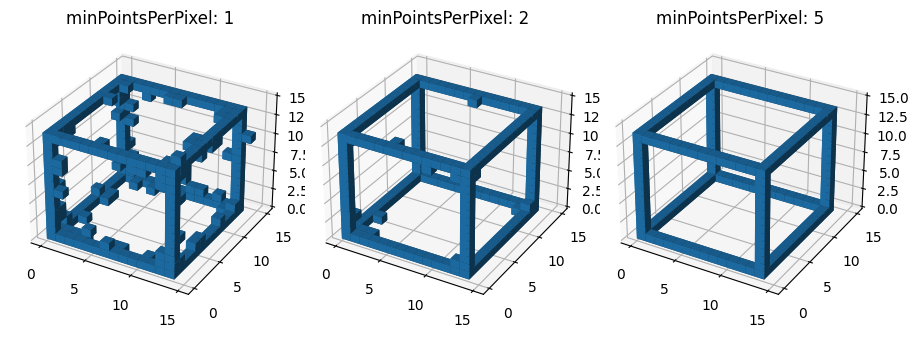

In [6]:
minPointsArr = [1, 2, 5]
imageMaxSize = 15
fig = plt.figure(figsize=(len(minPointsArr)*3, 4))

for i in range(len(minPointsArr)):
    
    img = sk.utils.pointsToImage(points, np.repeat(imageMaxSize, 3), 1, minPointsArr[i])
    
    ax = fig.add_subplot(1, len(minPointsArr), i+1, projection='3d')
    ax.voxels(img)
    ax.set_title(f'minPointsPerPixel: {minPointsArr[i]}')
    
fig.tight_layout()
plt.show()

In [145]:
skeleton = LaplacianContractionSkeleton(points)
skeleton.generateSkeleton()
skeleton.plot(backend='o3d', plotPoints=False, plotSkeleton=True)

MemoryError: Unable to allocate 29.2 GiB for an array with shape (62577, 62577) and data type float64